In [45]:
from datetime import datetime, timezone
import importlib
import os
from pathlib import Path
import sys

from arcgis.features import GeoAccessor, GeoSeriesAccessor
from arcgis.gis import GIS
from dateutil.relativedelta import relativedelta
from dotenv import load_dotenv, find_dotenv
import pandas as pd
import pytz

# import arcpy if available
if importlib.util.find_spec("arcpy") is not None:
    import arcpy

In [48]:
# paths to common data locations - NOTE: to convert any path to a raw string, simply use str(path_instance)
dir_prj = Path.cwd().parent

dir_data = dir_prj/'data'

dir_raw = dir_data/'raw'
dir_ext = dir_data/'external'
dir_int = dir_data/'interim'
dir_out = dir_data/'processed'

gdb_raw = dir_raw/'raw.gdb'
gdb_int = dir_int/'interim.gdb'
gdb_out = dir_out/'processed.gdb'

# import the project package from the project package path - only necessary if you are not using a unique environemnt for this project
sys.path.append(str(dir_prj/'src'))
import river_levels

# load the "autoreload" extension so that code can change, & always reload modules so that as you change code in src, it gets loaded
%load_ext autoreload
%autoreload 2

# load environment variables from .env
load_dotenv(find_dotenv())

# create a GIS object instance; if you did not enter any information here, it defaults to anonymous access to ArcGIS Online
gis = GIS(
    url=os.getenv('ESRI_GIS_URL'), 
    username=os.getenv('ESRI_GIS_USERNAME'),
    password=None if len(os.getenv('ESRI_GIS_PASSWORD')) is 0 else os.getenv('ESRI_GIS_PASSWORD')
)

gis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


GIS @ https://knu2xs.maps.arcgis.com version:9.2

In [49]:
from river_levels import Gauge

In [54]:
gauge = Gauge('01646500', 'usgs')

gauge

In [55]:
obs = gauge.get_observations(['cfs', 'temperature'], period='day', period_count=1)

obs

/Users/joel5174/projects/river-levels/src/river_levels/main.py:191: UserWarning: No data is available for the requested metric, temperature.
/Users/joel5174/projects/river-levels/src/river_levels/main.py:197: UserWarning: Although requested, temperature, does not appear to be available at this site.


,cfs
2021-07-20 14:00:00-04:00,3830.0
2021-07-20 14:15:00-04:00,3830.0
2021-07-20 14:30:00-04:00,3830.0
2021-07-20 14:45:00-04:00,3830.0
2021-07-20 15:00:00-04:00,3830.0
...,...
2021-07-21 12:45:00-04:00,3770.0
2021-07-21 13:00:00-04:00,3830.0
2021-07-21 13:15:00-04:00,3770.0
2021-07-21 13:30:00-04:00,3770.0


In [30]:
str_val = '99.4'

In [33]:
str_val.replace('.', '').isnumeric()

True

In [7]:
obs_df = pd.DataFrame(obs)
obs_df.value = obs_df.value.astype(float)
# obs_df.datetime = obs_df.datetime.apply(lambda dt_str: pd.to_datetime(dt_str))

print(obs_df.info())
obs_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175222 entries, 0 to 175221
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   value     175222 non-null  float64
 1   datetime  175222 non-null  object 
dtypes: float64(1), object(1)
memory usage: 2.7+ MB
None


,value,datetime
0,847.0,2016-07-21 00:00:00-07:00
1,847.0,2016-07-21 00:15:00-07:00
2,847.0,2016-07-21 00:30:00-07:00
3,847.0,2016-07-21 00:45:00-07:00
4,847.0,2016-07-21 01:00:00-07:00
...,...,...
175217,912.0,2021-07-21 04:30:00-07:00
175218,912.0,2021-07-21 04:45:00-07:00
175219,912.0,2021-07-21 05:00:00-07:00
175220,904.0,2021-07-21 05:15:00-07:00


In [83]:
obs_df['timestamp'] = obs_df.datetime.apply(lambda dt: dt.astimezone(pytz.timezone('US/Pacific')))

obs_df = obs_df.drop(columns=['datetime']).set_index('dt_tz')

obs_df

,value
dt_tz,
2016-07-20 00:00:00-07:00,904.0
2016-07-20 00:15:00-07:00,904.0
2016-07-20 00:30:00-07:00,904.0
2016-07-20 00:45:00-07:00,904.0
2016-07-20 01:00:00-07:00,904.0
...,...
2021-07-20 19:30:00-07:00,945.0
2021-07-20 19:45:00-07:00,945.0
2021-07-20 20:00:00-07:00,945.0


In [84]:
mean_df = obs_df.rolling('5D').mean()

mean_df.info()
mean_df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 175282 entries, 2016-07-20 00:00:00-07:00 to 2021-07-20 20:30:00-07:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   value   175282 non-null  float64
dtypes: float64(1)
memory usage: 2.7 MB


,value
dt_tz,
2016-07-20 00:00:00-07:00,904.0
2016-07-20 00:15:00-07:00,904.0
2016-07-20 00:30:00-07:00,904.0
2016-07-20 00:45:00-07:00,904.0
2016-07-20 01:00:00-07:00,904.0


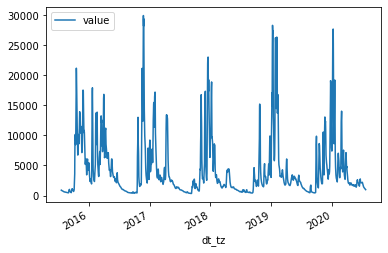

In [74]:
_ = mean_df.plot()

In [76]:
dt.timetuple().tm_yday

202